# Inspect time series based on Dat

In [1]:
#Import required libraries
import os
import numpy as np
import pandas as pd
import data_reader.data_processing as proc
import matplotlib.pyplot as plt
import analyses.saturated_transient as sta
import h5py

In [2]:
sourcedatadir = "E:/Saturated_flow/EGUGoldschmidtdataset6"
hdf5directory = "Y:/Home/khurana/4. Publications/Restructuring"
Regimes = ["Slow", "Medium", "Fast"]

## Generate a time series file (HDF5 format) to store all the data

### Data is essentially concentration of reactive species leaving the domain normalized by that in the uniform flow scenario

In [ ]:
h5file = h5py.File(os.path.join(hdf5directory, "Paper2", "Figurecodes","Temporal_analysis_full.h5"), mode = 'w')
for Reg in Regimes:
    basedata = np.load(os.path.join(sourcedatadir, Reg + "AR_0/NS-AH/NS-AH_df.npy"))
    basevelocity = np.mean(basedata[2, -1, :, :])
    for t in imposedtimeseries:
        directory = os.path.join(sourecdatadir,Reg + "AR_" + t)
        print (Reg, t)
        for j in Trial:
                if ((j == '52' and t == "5") or (j == '43' and t == "1")):
                    pass
                else:
                    basefile = os.path.join(Reg + "AR_0","NS-A"+j,"NS-A"+j+"_df.npy")
                    basedata = np.load(os.path.join(sourcedatadir, basefile))
                    baseconcs, flow, heads = sta.calcconcmasstimenew (basedata,0,-1,0,-1, 51, gvarnames, "Saturated")
                    data = np.load(os.path.join(directory, "NS-A"+j,"NS-A"+j"_df.npy")
                    concs, flow, heads = sta.calcconcmasstimenew (data,0,-1,0,-1, 51, gvarnames, "Saturated")
                    subconcs = concs[1:, -1, :]/baseconcs[-1, -1,:]
                    for g in gvarnames:
                        h5file.create_dataset(t + "/" + Reg + "/" + j + "/" + g, data=subconcs[:, gvarnames.index(g)])
h5file.close()

### Identify the time series and categorize in Dat categories from Paper 1 effort

In [3]:
#Generate Dat from Da and Pe
data  = pd.read_csv(os.path.join(hdf5directory,"Paper1","Figurecodes", "Da_29012021_95pcloss.csv"), sep=",")
for Reg,p in zip(Regimes,[2,11,22]):
    data.loc[data.Regime==Reg, "Dat"] = np.log(data[data.Regime==Reg]["Da63"]/p)
print(data.head)

<bound method NDFrame.head of      Unnamed: 0 Regime  Velocity  Pe Trial      Chem  Conc_in    Conc_out  \
0             0   Slow   0.00038   2     H       DOC    800.0  326.102310   
1             1   Slow   0.00038   2     H        DO    250.0    1.068140   
2             2   Slow   0.00038   2     H  Ammonium     60.0   48.128075   
3             3   Slow   0.00038   2     H   Nitrate    250.0   63.325155   
4             4   Slow   0.00038   2     H  Nitrogen    312.4  134.363090   
..          ...    ...       ...  ..   ...       ...      ...         ...   
877         877   Fast   0.03800  22    84        DO    250.0   59.679536   
878         878   Fast   0.03800  22    84  Ammonium     60.0   54.431746   
879         879   Fast   0.03800  22    84   Nitrate    250.0  239.253473   
880         880   Fast   0.03800  22    84  Nitrogen    312.4  301.159065   
881         881   Fast   0.03800  22    84       TOC    824.0  671.356896   

     Normconc      base  ...  temporal_reldel

In [4]:
#Consider time series in terms of Dat.
#Sort all the values in Dat
gvarnames = ["DOC", "DO", "Nitrogen", "TOC"]
finaldata = data[data['Chem'].isin (gvarnames)]
mymarklist = ["^", "o", "s", "d"]
reglist = ["Slow", "Medium", "Fast"]
colorlist = ["indianred", "g", "steelblue"]

finaldata.loc[finaldata["Dat"] > 0, "PeDamark"] = 3
finaldata.loc[(finaldata["Dat"] > -2) & (finaldata["Dat"] < 0), "PeDamark"] = 2
finaldata.loc[(finaldata["Dat"] > -6) & (finaldata["Dat"] < -2), "PeDamark"] = 1
finaldata.loc[finaldata["Dat"] < -6, "PeDamark"] = 0

labels = {0 : r'$Da_t < -6$',
          1 : r'$-6 < Da_t < -2$',
          2 : r'$-2 < Da_t < 0$',
          3 : r'$Da_t > 0$'}

subfinal = finaldata[["Trial", "Regime", "Chem", "Time_series","PeDamark"]]
subfinal['key'] = subfinal.Trial + subfinal.Regime + subfinal.Chem + subfinal.Time_series.astype(str)
colorcriteria = subfinal[["PeDamark", "key"]].to_dict('records')
colorcriteria = dict(zip(subfinal['key'], subfinal['PeDamark']))

PeDapalette = {0: "grey", 1: "orange", 2: "g", 3: "indianred"}

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

### Generate the time series again, but now categorizing each scenario instead of Regime/Trial/Chemical

In [22]:
#Load already generated time series
hr = h5py.File(os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_data.h5"), mode = 'r')
#Write new time series in a new HDF5 file
hw = h5py.File(os.path.join(hdf5directory,"Paper2","Figurecodes","Temporal_analysis_full_Dat.h5"), mode = 'w')
print(hr.keys())

for t in imposedtimeseries:
    n0=[]
    n1=[]
    n2=[]
    n3=[]
    for Reg in reginvest:
        if Reg == "Equal":
            r = "Medium"
        else:
            r = Reg    
        for g in gvarnames:
            for j in Trial:
                if ((j == '52' and t == "5") or (j == '43' and t == "1")):
                    pass
                else:                   
                    n = hr.get(t + "/" + Reg + "/" + j + "/" + g).value
                    if int(colorcriteria[j+r+g+t]) == 0:
                        n0.append(n)
                    elif int(colorcriteria[j+r+g+t]) == 1: 
                        n1.append(n)
                    elif int(colorcriteria[j+r+g+t]) == 2:
                        n2.append(n)
                    elif int(colorcriteria[j+r+g+t]) == 3:
                        n3.append(n)
    for Dat, k in zip([0,1,2,3],[n0, n1, n2, n3]):
        df = pd.DataFrame.from_records(k)
        #Then take average at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/mean/", data=df.mean())
        #Then take minimum at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/min/", data=df.min())
        #Then take maximum at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/max/", data=df.max())
hr.close()
hw.close()

OSError: Unable to open file (unable to open file: name = 'Y:/Home/khurana/4. Publications/Restructuring\Paper2\Figurecodes\Temporal_analysis_full_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Plot the time series in terms of Dat

<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value


(1095,)
(1095,)
(1095,)
(1095,)


<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value


(1095,)
(1095,)
(1095,)
(1095,)


<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value
<ipython-input-6-f1400d13f93c>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/Dat" + str(Dat) + "/").value


(1095,)
(1095,)
(1095,)
(1095,)


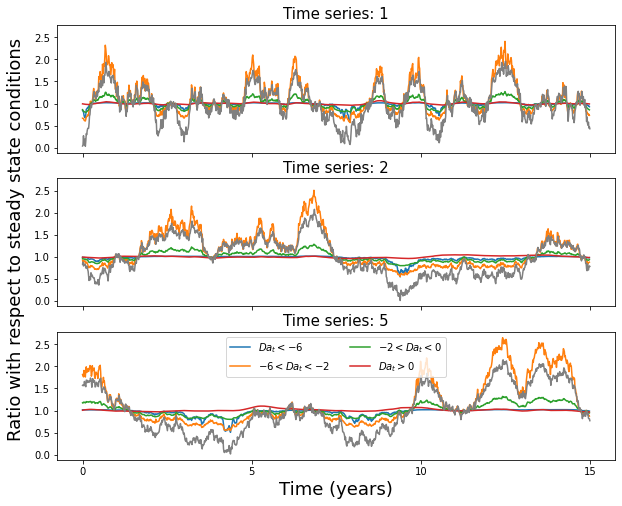

In [6]:
#Characteristic to plot:
datafeature = "mean"
imposedtimeseries = ["1","2","5"]
#Load dataset for time series in terms of Dat
hr = h5py.File(os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_Dat.h5"), mode = 'r')
#Load dataset for base velocity ratio values which will be plotted in the graph
basedata = np.load(os.path.join(sourcedatadir, "SlowAR_0/NS-AH/NS-AH_df.npy"))
basevelocity = np.mean(basedata[2, -1, :, :])
fig, ax = plt.subplots(3, 1, figsize = (10,8), sharey = True, sharex = True)
for t in imposedtimeseries:
    a = ax.flat[imposedtimeseries.index(t)]
    a.set_title("Time series: T"+ t, fontsize = 16)
    for Dat in [0,1,2,3]:
        n = hr.get(t + "/Dat" + str(Dat) + "/").value
        print(np.shape(n))
        a.plot(n[1:], label = labels[Dat])
        #a.plot(np.convolve(n[1:], np.ones((3,))/3,mode = 'valid'), label = Dat)
    directory = os.path.join(sourcedatadir, "SlowAR_" + t)
    for j in ["37"]:
        a = ax.flat[imposedtimeseries.index(t)]
        data = np.load(os.path.join(directory,"NS-A"+j,"NS-A"+j+"_df.npy"))
        velocity = np.mean(data[2, :, :, :], axis = (-1,-2))/basevelocity
        a.plot(np.abs(velocity[1:]), color= "gray")
a.legend(ncol = 2)
#locs, labels1 = a.xticks()
plt.xticks((0,365,730,1095), (0,5,10,15))
a.set_xlabel ("Time (years)", fontsize = 18)
for a, typsp in zip(ax, imposedtimeseries):
    a.set_title("Time series: "+typsp, fontsize=15)
plt.annotate("Ratio with respect to steady state conditions",
        xy=(0, 1.8),
        xytext=(-50, -10),
        xycoords="axes fraction",
        textcoords="offset points",
        size="large",
        ha="left",
        va="center",
        rotation="vertical",
        fontsize=18)
picname = os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_data.png")
plt.savefig(picname, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)
hr.close()